# compare the OpenPIV Python with PIVLab


In [1]:
%reload_ext watermark
%watermark -v -m -p numpy,openpiv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

numpy  : 1.19.4
openpiv: 0.23.3

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
from openpiv import windef

import numpy as np
import os
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)


In [3]:
settings = windef.Settings()

# 'Data related settings'
# Folder with the images to process
settings.filepath_images = '../data/'
# Folder for the outputs
settings.save_path = '../OpenPIV_results/'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Test_1'
# Format and Image Sequence
settings.frame_pattern_a = 'karman_16Hz_000_A.jpg'
settings.frame_pattern_b = 'karman_16Hz_000_B.jpg'

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
# settings.ROI = 'full'
settings.ROI = (200,400,500,900)

settings.deformation_method = 'symmetric' # or 'second image'


settings.num_iterations = 5  # select the number of PIV passes

# add the interrogation window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes=(64, 32, 16, 8, 6)
settings.overlap=(32, 16, 8, 4, 3)

# settings.windowsizes = (128, 64, 32, 16, 8) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
# settings.overlap = (64, 32, 16, 8, 4) # This is 50% overlap


# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'

# order of the image interpolation for the window deformation
settings.interpolation_order = 1
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)
'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
settings.sig2noise_threshold = 1.1
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
settings.do_sig2noise_validation = True

# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN

# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated

'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = False
settings.scale_plot = 200  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings



# 'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
settings.normalized_correlation = False

# 'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True


settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 10
settings.filter_kernel_size = 2  # kernel size for the localmean method

settings.replace_vectors = True

settings.MinMax_U_disp = (-30, 30)
settings.MinMax_V_disp = (-30, 30)

# The second filter is based on the global STD threshold
settings.std_threshold = 5  # threshold of the std validation

# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size = 2 #defines the size of the local median, it'll be 3 x 3


settings.dynamic_masking_method = 'intensity'
settings.dynamic_masking_threshold = 0.1
settings.dynamic_masking_filter_size = 21

# New settings for version 0.23.2c
settings.image_mask = True

# Smoothing after the first pass
settings.smoothn = False #Enables smoothing of the displacemenet field
settings.smoothn_p = 0.5 # This is a smoothing parameter


In [4]:
import glob
file_list = sorted(glob.glob('../data/karman_16Hz_*.jpg'))
file_list = file_list[-2:]
file_list

['../data/karman_16Hz_010_A.jpg', '../data/karman_16Hz_010_B.jpg']

../data/karman_16Hz_010_A.jpg ../data/karman_16Hz_010_B.jpg


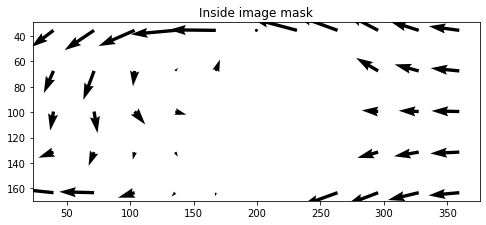

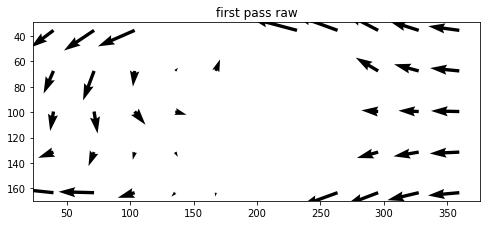

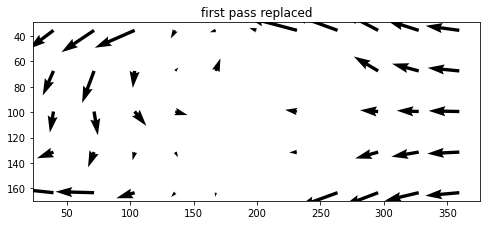

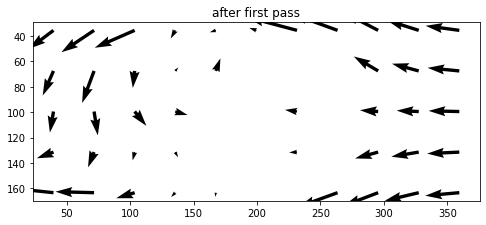

going to 32
sig2noise method is None


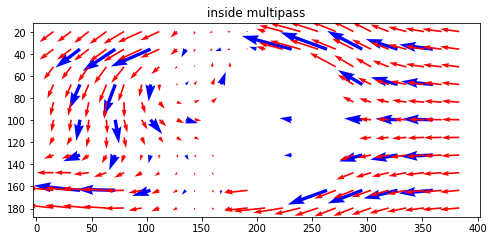

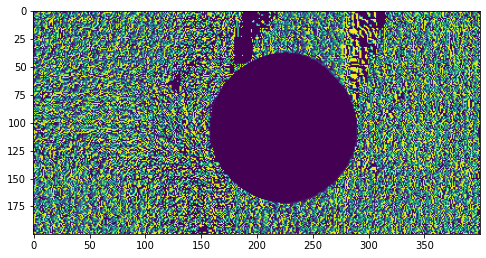

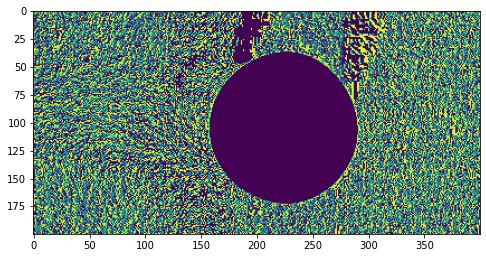

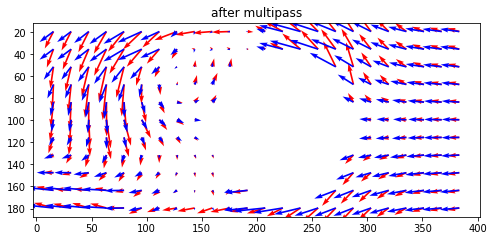

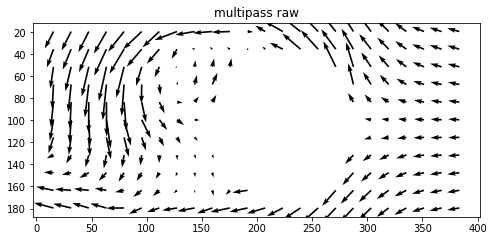

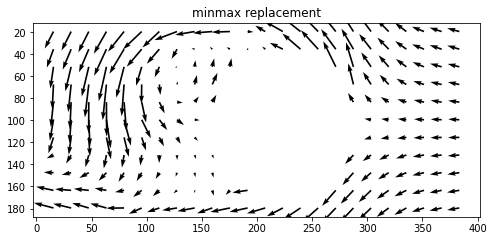

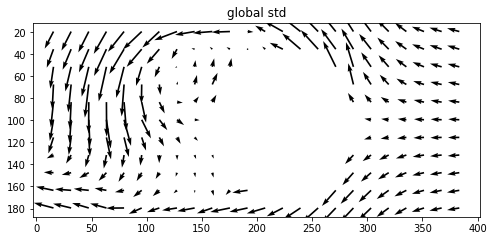

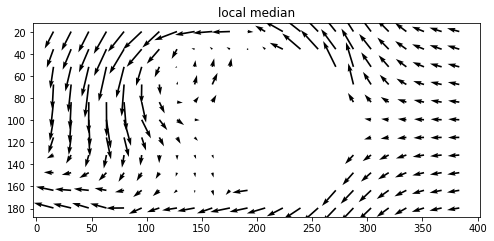

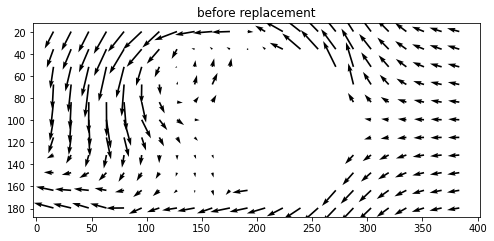

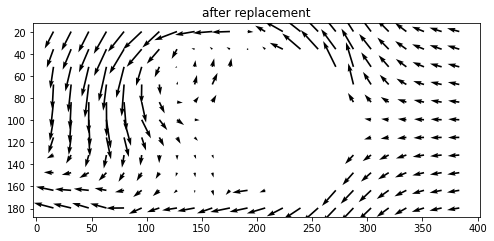

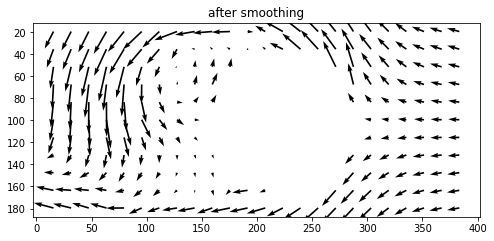

going to 16
sig2noise method is None


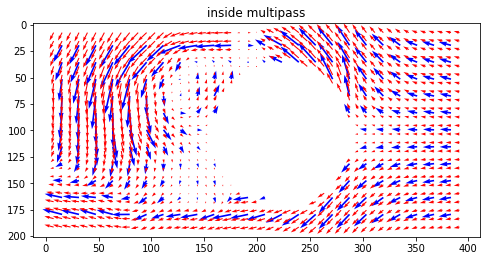

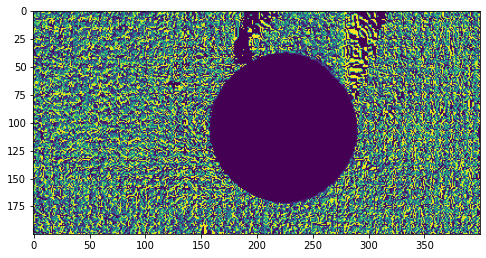

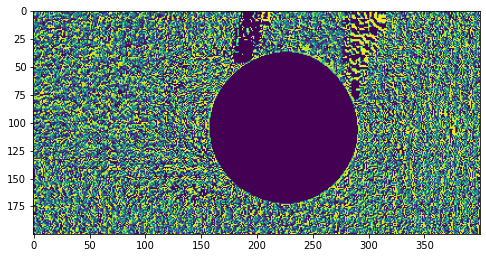

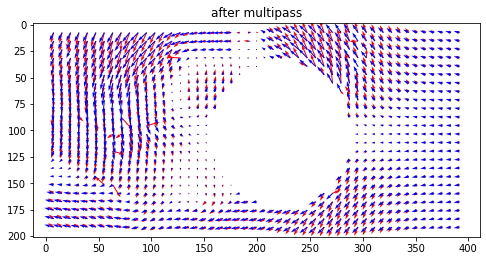

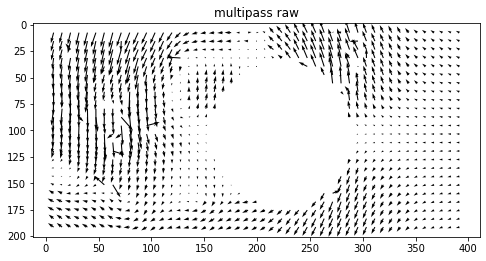

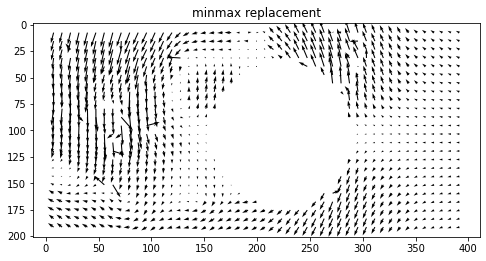

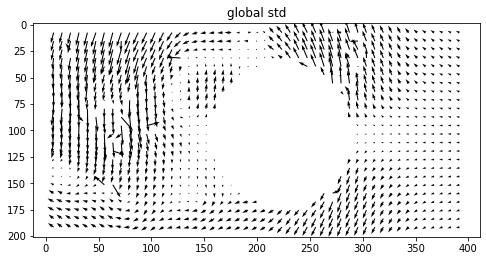

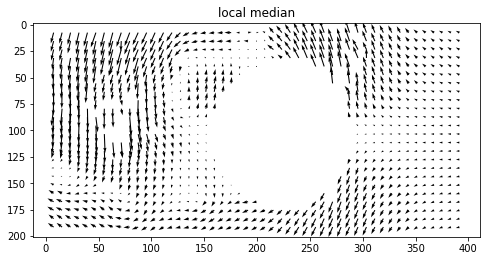

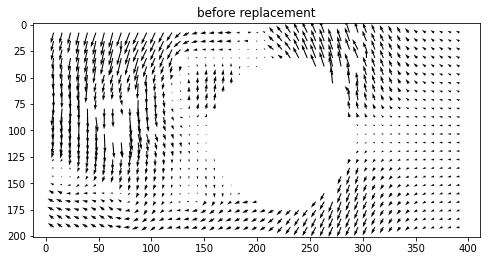

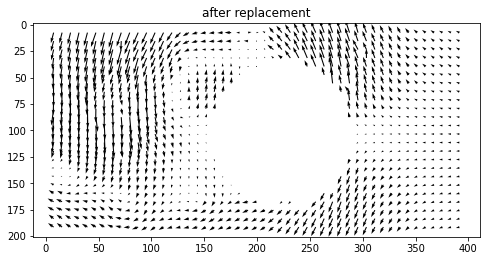

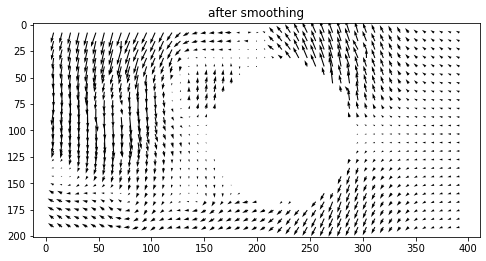

going to 8
sig2noise method is None


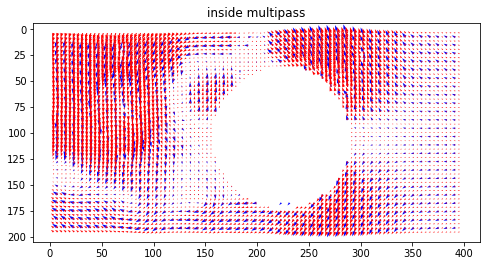

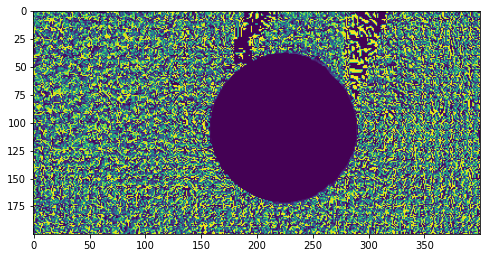

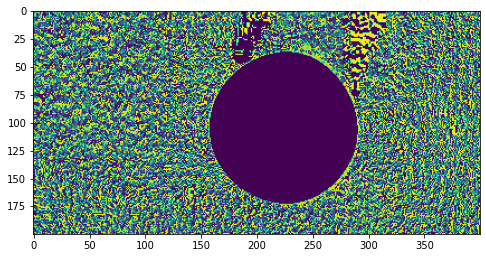

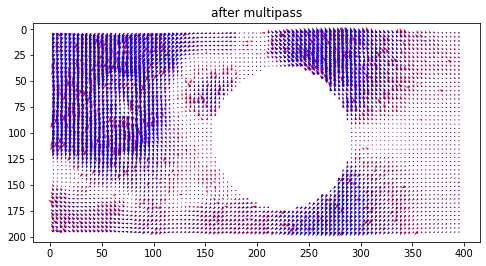

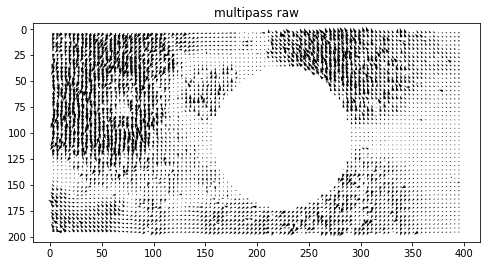

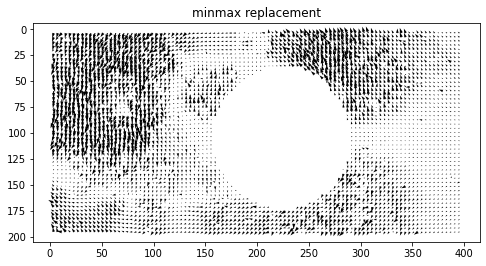

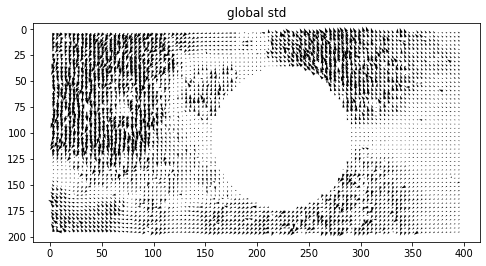

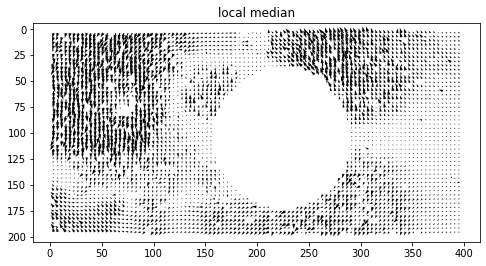

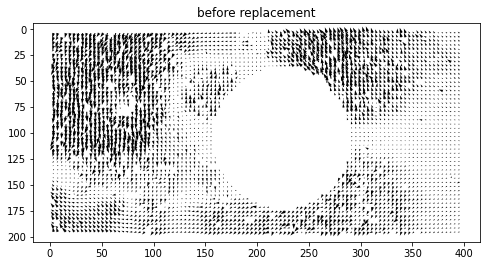

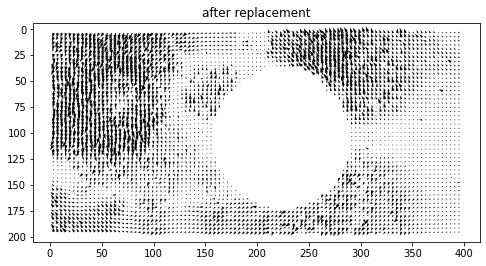

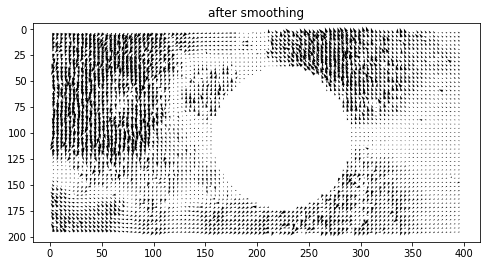

going to 6
sig2noise method is peak2peak


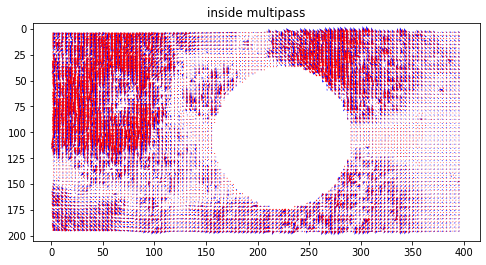

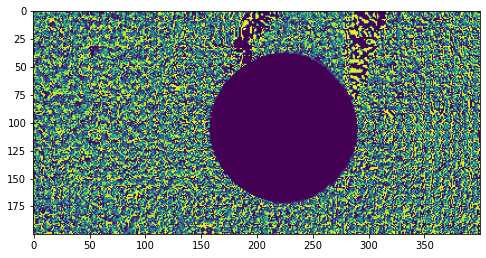

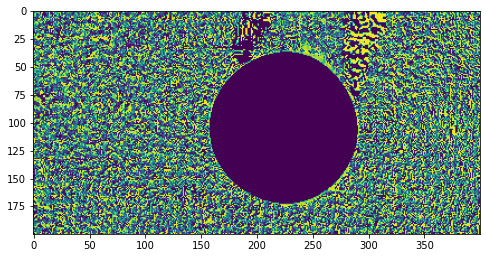

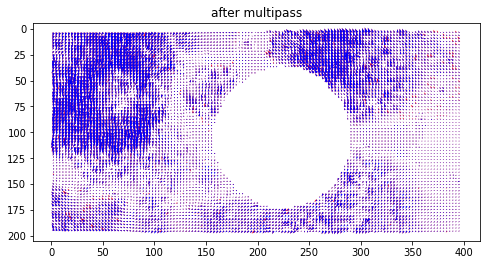

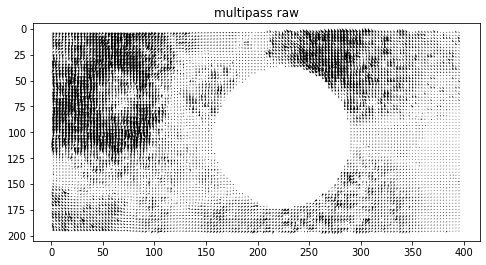

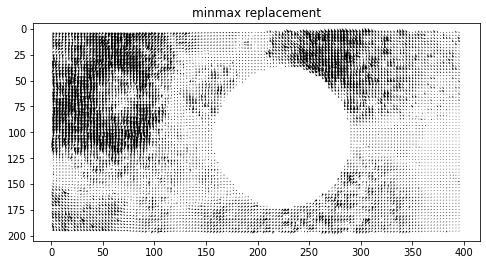

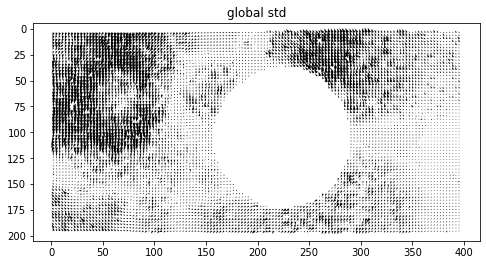

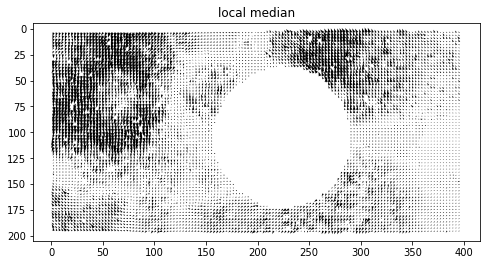

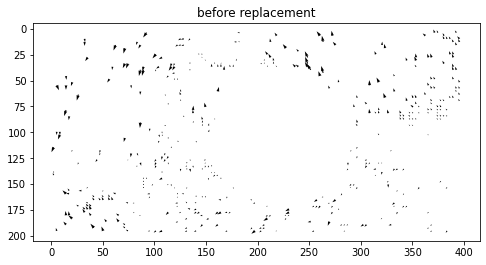

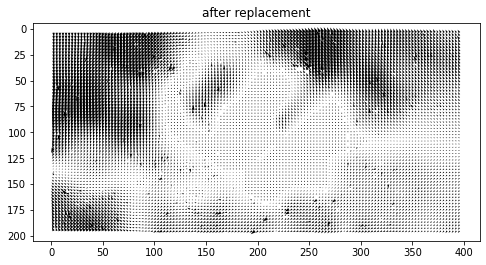

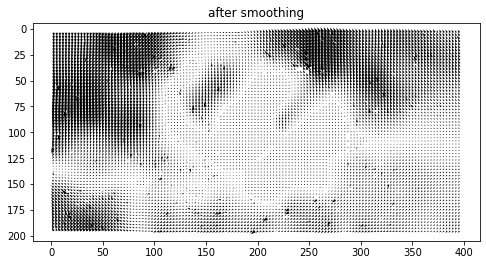

Image Pair 1


In [5]:
N = 1
counter = 0
for a,b in zip(file_list[0:2*N+1:2],file_list[1:2*N+2:2]):
    print(a,b)
    settings.frame_pattern_a = a
    settings.frame_pattern_b = b
    settings.save_folder_suffix = f'{counter}'
    windef.piv(settings)
    counter += 1

In [6]:
from pivpy import pivpy, io, graphics
import xarray as xr

In [7]:
import glob
file_list = sorted(glob.glob('../OpenPIV_results/Open_PIV_results_6_0/*.txt'))

data = []
frame = 0
for f in file_list:
    data.append(io.load_txt(f,frame=frame))
    frame += 1
    
data = xr.concat(data,dim='t')
data.attrs['units']= ['pix','pix','pix/dt','pix/dt']

In [8]:
data.piv.vorticity()

<xarray.Dataset>
Dimensions:  (t: 1, x: 132, y: 65)
Coordinates:
  * t        (t) int64 0
  * x        (x) float64 2.5 5.5 8.5 11.5 14.5 ... 383.5 386.5 389.5 392.5 395.5
  * y        (y) float64 3.5 6.5 9.5 12.5 15.5 ... 183.5 186.5 189.5 192.5 195.5
Data variables:
    u        (x, y, t) float64 0.2677 0.2553 0.2417 ... -1.938 -1.94 -1.941
    v        (x, y, t) float64 -5.317 -5.327 -5.339 ... -2.542 -2.571 -2.594
    chc      (x, y, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 1.045 0.0 0.0
    w        (x, y, t) float64 0.0017 0.00225 0.001217 ... -0.00815 -0.0072
Attributes:
    variables:  None
    units:      ['pix', 'pix', 'pix/dt', 'pix/dt', '1/dt']
    dt:         None
    files:      ../OpenPIV_results/Open_PIV_results_6_0/field_A000.txt

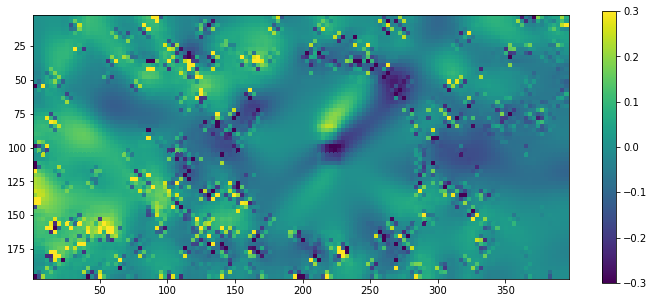

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,5))
# for ax in axs:
s = ax.pcolor(data.x,data.y,data.w.T.isel(t=0), shading='nearest', vmin=-.3, vmax=.3)
ax.invert_yaxis()
ax.set_aspect(1)
fig.colorbar(s, ax=ax,)

In [10]:
data.w.T.values

array([[[ 0.0017    ,  0.00231667,  0.00586667, ...,  0.04935   ,
          0.20965   ,  0.07      ],
        [ 0.00225   ,  0.00298333,  0.00723333, ...,  0.04793333,
          0.122     ,  0.03155   ],
        [ 0.00121667,  0.00215   ,  0.00723333, ...,  0.04441667,
          0.24136667,  0.47481667],
        ...,
        [ 0.007     ,  0.01891667,  0.02711667, ..., -0.01641667,
         -0.01381667, -0.01373333],
        [ 0.01665   , -0.05998333,  0.04343333, ..., -0.00968333,
         -0.00835   , -0.00815   ],
        [-0.31953333, -0.14281667,  0.21753333, ..., -0.0094    ,
         -0.00755   , -0.0072    ]]])